# Week 5: Image Histograms


In [1]:
import numpy as np
import copy
import cv2
import matplotlib
# matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import random
import copy
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')

## Task 1: Compute Histogram
Histograms can be rather important when it comes to adjusting the brightness of an image.
Your first task is to compute a histogram of an image of your choice and display this as a plot.

*Note: Do not use any libraries, write your own function*

In [2]:
def compute_hist(img):
    '''
    Impelemnt 
    :param img: gray scaled image with size HxW
    :return: 
    '''
    hist = np.zeros(256)
    for i in img.flatten():
        hist[i] += 1
    return hist

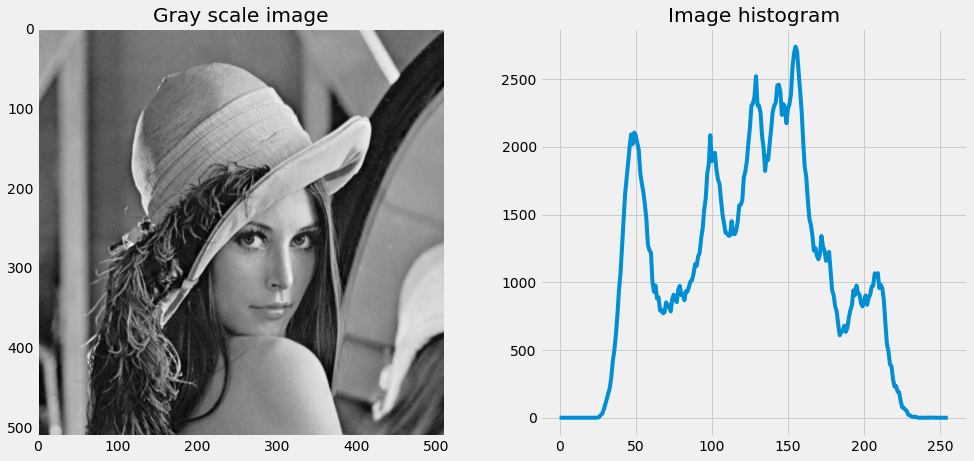

In [3]:
img = cv2.imread('../images/Lenna.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_hist = compute_hist(gray_img)

# Show Original and segmented image
fig, axis = plt.subplots(1, 2, figsize=(15,7), sharey=False)
#fig.subplots_adjust(wspace=-0.2, hspace=0.0)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')

axis[1].plot(img_hist)
axis[1].set_title('Image histogram')

plt.show()

## Task 2: Histogram Equalisation
Histogram Equalisation is often used to adjust the global contrast of an image.
It is most useful when an image’s background is either too dark or too light and can bring out more detail in under exposed images.

This can be done by finding a mapping function $F: [0, 255] \rightarrow [0, 255]$:

$$
    F(v) = \frac{cdf(v) - cdf_{min}}{(M \times N) - cdf_{min}}x(L - 1)
$$

Where $v$ is the current value to be adjusted, $(M \times N)$ is the size of the image and $L$ is the number of intensity levels i.e. 256. The cdf is the cumulative distribution of the histogram.

Your task would be to calculate the new mappings, apply this to the image and plot the new equalised histogram. As shown below:

In [8]:
def hist_equalisation(img, img_hist):
    '''
    Impelemnt 
    :param img: gray scaled image with size HxW
    :param img_hist: [256,]
    :param L:
    :return: image segmentation of size HxW
    '''
    L = img_hist.shape[0]
    M, N = img.shape
    cdf = np.array([np.sum(img_hist[:i]) for i in range(L)])
    cdf_min = np.min(cdf)
    factor = (L-1) / (M*N - cdf_min)
    output = np.zeros((M,N), dtype=np.int)
    for i in range(M):
        for j in range(N):
            output[i,j] = int(cdf[img[i,j]] - cdf_min)*factor
    return output


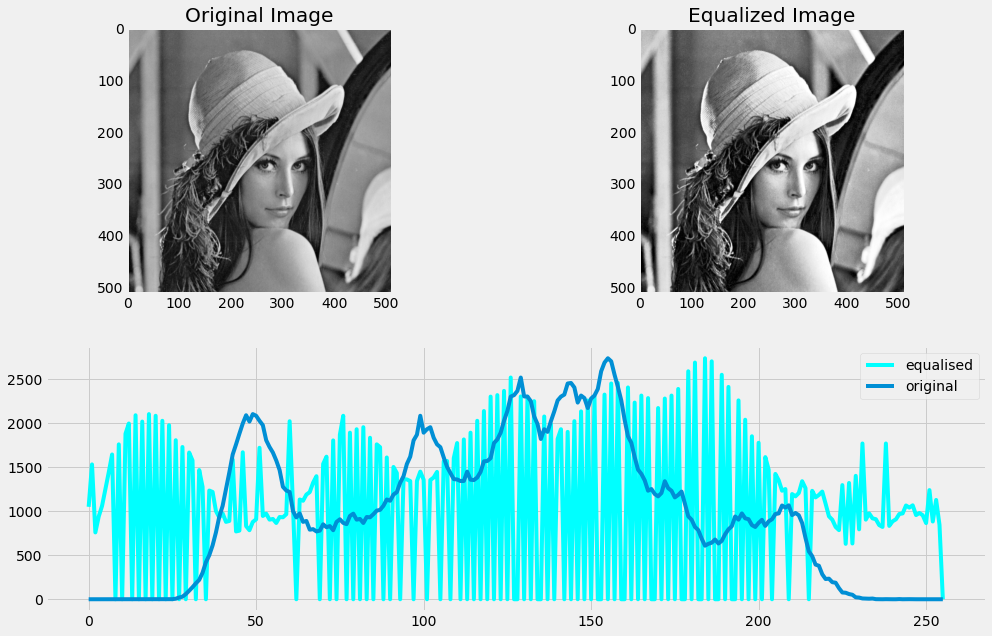

In [9]:
eqImg = hist_equalisation(gray_img, img_hist)
eqImg_hist = compute_hist(eqImg.astype(int))

# Plot Original and Equalised image
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.imshow(gray_img, 'gray')
plt.grid(False)
plt.title('Original Image')

plt.subplot(222)
plt.imshow(eqImg, 'gray')
plt.grid(False)
plt.title('Equalized Image')

plt.subplot(212)
plt.plot(eqImg_hist, color='cyan', label='equalised')
plt.plot(img_hist, label='original')
plt.legend()

plt.show()

## Task 3: Histogram Matching

Your next task is to be able to adjust an image based on the histogram of another.
This is done using histogram matching and can be helpful if you would like to adjust a series of images with different global illuminations. Using histogram matching you could adjust this image’s brightness (and contrast) to match the other better illuminated images.

To perform histogram matching we need to first calculate the normalised CDF of the **source image** and the **target image**: `cdfSource` and `cdfTarget`.

The normalised CDF for each image is obtained by dividing the value in each bin of the original CDF with the maximum value of the original CDF (last bin of the original CDF), so we get a value between 0 and 1 in each bin of the normalised CDF.

We then need to find a mapping function `F` that maps `cdfSource` to `cdfTarget`. This mapping function can then be applied to the input image. The mapping function needed is quite simple and can be obtained by comparing the values between cdfSource and cdfTarget. One way to do this, is to find the first `cdfSource(valueS)` that is greater than `cdfTarget(valueT)`, and that valueT will be the mapping `F(valueS)`. The figure below is a demonstration on how this mapping function works:

<img src="../images/histogram-cdf.png" alt="drawing" width="700"/>

In [39]:
def hist_match(source_img, target_img):
    '''
    Impelemnt 
    :param source_img: gray scaled image with size HxW
    :param target_img: 
    :return: image 
    '''
    source_hist = compute_hist(source_img)
    target_hist = compute_hist(target_img)

    source_cdf = np.array([np.sum(source_hist[:i]) for i in range(source_hist.shape[0])])
    target_cdf = np.array([np.sum(target_hist[:i]) for i in range(target_hist.shape[0])])
    # get normalized hist:
    source_hist_normalized = source_cdf / source_cdf[-1]
    target_hist_normalized = target_cdf / target_cdf[-1]
    
    # map the intensity of the source to the target
    # by setting the intensity of the source same to the target where their cdf are equal
    M, N = source_img.shape
    output = np.zeros((M,N), dtype=np.int)
    for i in range(M):
        for j in range(N):
            # get the intensity of target img with same cdf
            cdf = source_hist_normalized[source_img[i,j]]
            intensity = len(target_hist[target_hist_normalized<cdf])
            # print(cdf, intensity)
            output[i,j] = intensity

    return output, source_hist, target_hist
    

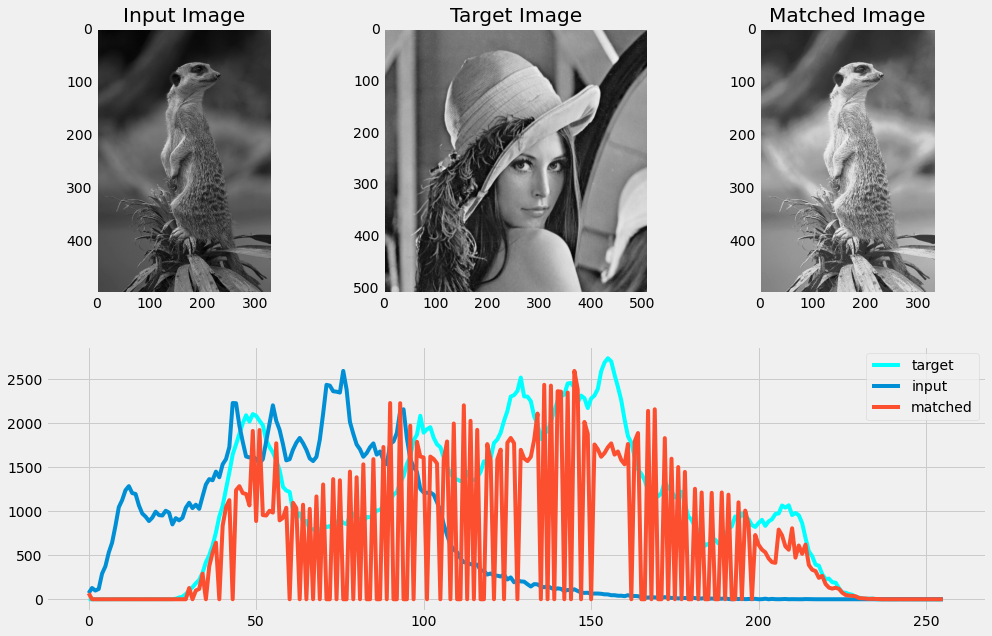

In [40]:
src_img = cv2.imread('../images/meerkat.jpg')
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
tgt_img = gray_img
tgt_hist = img_hist

matched_img, src_hist, tag_hist = hist_match(src_img, tgt_img)
matched_hist = compute_hist(matched_img.astype(int))


# Plot Input, Output and Matched image
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(src_img, 'gray')
plt.grid(False)
plt.title('Input Image')

plt.subplot(232)
plt.imshow(gray_img, 'gray')
plt.grid(False)
plt.title('Target Image')

plt.subplot(233)
plt.imshow(matched_img, 'gray')
plt.grid(False)
plt.title('Matched Image')

plt.subplot(212)
plt.plot(tgt_hist, color='cyan', label='target')
plt.plot(src_hist, label='input')
plt.plot(matched_hist, label='matched')
plt.legend()

plt.show()

## Task 4: Image Transformations
Your last task is rather simple and just requires you to run an example.
The idea is just to show you a beneficial use of applying affine or perspective transformations to images and how this could be used in practice.

First load and show the images:

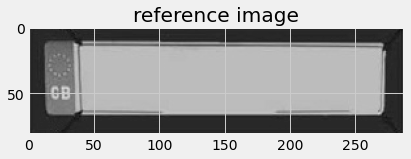

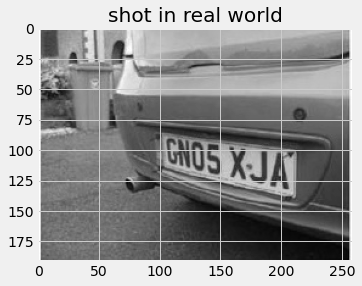

In [41]:
tag_img = cv2.imread('../images/plate_side.jpg')
tag_img = cv2.cvtColor(tag_img, cv2.COLOR_BGR2GRAY)

ref_img = cv2.imread('../images/reference.jpg')
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.title("reference image")
plt.imshow(ref_img, 'gray')
plt.show()

plt.figure()
plt.title("shot in real world")
plt.imshow(tag_img, 'gray')
plt.show()

Then select four points on both images. You can do this by enabling the interactive mode of `matplotlib`. If you struggle with the interactive mode, you can use the following as a reference:

In [198]:
# Set the points of the documents or object which you want to transform
ref_pts = np.array([[11.8, 11.0],
                    [270.9, 13.1],
                    [270.9, 67.9],
                    [14.9, 67.4]])  # [4, 3]: top-left, top-right, bottom-right, bottom-left

tag_pts = np.array([[95.6, 84.0],
                    [211.6, 101.3],
                    [211.1, 141.3],
                    [97.6, 112.2]])

In [199]:
# original @ W = reference
def getPerspectiveTransform(original, reference):
    length = original.shape[0]
    original = np.hstack((original, np.ones((length, 1))))
    reference = np.hstack((reference, np.ones((length, 1))))
    W = np.linalg.pinv(original) @ reference
    return W

def warpPerspective(original, matrix, reference_shape):
    N, M = reference_shape
    m, n = original.shape
    W_inv = np.linalg.pinv(matrix)
    output = np.zeros((M, N))
    
    for i in range(M):
        for j in range(N):
            orig_pos = np.array([i, j, 1]) @ W_inv
            orig_pos = orig_pos / orig_pos[-1]
            # print(orig_pos)
            # should work without this:
            x, y = max(orig_pos[0], 0), max(orig_pos[1], 0)
            x, y = int(min(x, n-1)), int(min(y,m-1))
            output[i,j] = original[x, y]
    return output

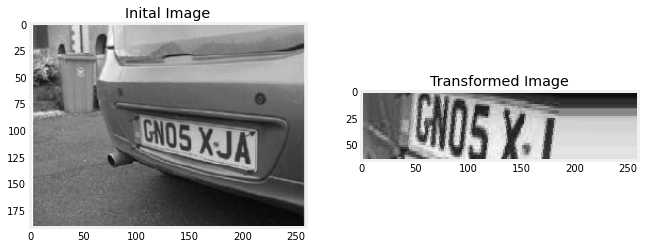

In [200]:
# switch to inline plot and we can see plots in the notebook
%matplotlib inline

# Apply Perspective Transform Algorithm
matrix = getPerspectiveTransform(np.float32(tag_pts), np.float32(ref_pts))
# cvmatrix = cv2.getPerspectiveTransform(np.float32(tag_pts), np.float32(ref_pts))
# print(matrix, cvmatrix)
result = warpPerspective(tag_img, matrix, (260, 65))
# Wrap the transformed image

# Plot Input, Output and Matched image
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(result, 'gray')
plt.grid(False)
plt.title('Transformed Image')

plt.show()